# Introduction

Parkinson's disease (PD) is a long-term neurodegenerative disease of the central nervous system that affects both the motor and non-motor systems of the body.

In [346]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [347]:
df = pd.read_csv('./data/parkinsons_disease_data.csv')
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,...,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,...,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,...,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,...,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,...,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid


In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PatientID                 2105 non-null   int64  
 1   Age                       2105 non-null   int64  
 2   Gender                    2105 non-null   int64  
 3   Ethnicity                 2105 non-null   int64  
 4   EducationLevel            2105 non-null   int64  
 5   BMI                       2105 non-null   float64
 6   Smoking                   2105 non-null   int64  
 7   AlcoholConsumption        2105 non-null   float64
 8   PhysicalActivity          2105 non-null   float64
 9   DietQuality               2105 non-null   float64
 10  SleepQuality              2105 non-null   float64
 11  FamilyHistoryParkinsons   2105 non-null   int64  
 12  TraumaticBrainInjury      2105 non-null   int64  
 13  Hypertension              2105 non-null   int64  
 14  Diabetes

In [349]:
df.isna().sum() # There are no null values

PatientID                   0
Age                         0
Gender                      0
Ethnicity                   0
EducationLevel              0
BMI                         0
Smoking                     0
AlcoholConsumption          0
PhysicalActivity            0
DietQuality                 0
SleepQuality                0
FamilyHistoryParkinsons     0
TraumaticBrainInjury        0
Hypertension                0
Diabetes                    0
Depression                  0
Stroke                      0
SystolicBP                  0
DiastolicBP                 0
CholesterolTotal            0
CholesterolLDL              0
CholesterolHDL              0
CholesterolTriglycerides    0
UPDRS                       0
MoCA                        0
FunctionalAssessment        0
Tremor                      0
Rigidity                    0
Bradykinesia                0
PosturalInstability         0
SpeechProblems              0
SleepDisorders              0
Constipation                0
Diagnosis 

There are multiple categorical features in this dataset, all of which have been imputed with integers $0, 1, 2,\cdots$. Although there are those that are actually ordinal in nature, i.e. there is an assumed order, most are not. Importantly, they also make EDA somewhat difficult. Hence, only for the EDA portion of the analysis, these features (at least the ones which are not simply yes/no) will be converted into string columns with the appropriate labels. Another important reason for doing this is that ordinal encoding will give erroneous results when training a machine learning model.

**Legend:**
1. Gender - 0 (Male), 1 (Female) 
2. Ethnicity - 0 (Caucasian), 1 (African American), 2 (Asian), 3 (Other) (quite a restrictive set)
3. Educational level - 0 (None), 1 (High School), 2 (Bachelor's), 3 (Higher) (there is ordinality in this encoding)
4. Smoking - 0 (No), 1 (Yes)
5. Family history of Parkinson's - 0 (No), 1 (Yes)
6. Traumatic brain injury - 0 (No), 1 (Yes)
7. Hypertension - 0 (No), 1 (Yes)
8. Diabetes - 0 (No), 1 (Yes)
9. Depression - 0 (No), 1 (Yes)
10. History of stroke - 0 (No), 1 (Yes)
11. Tremors - 0 (No), 1 (Yes)
12. Rigidity - 0 (No), 1 (Yes)
13. Bradykinesia - 0 (No), 1 (Yes)
14. Postural instability - 0 (No), 1 (Yes)
15. Speech problems - 0 (No), 1 (Yes)
16. Sleep disorders - 0 (No), 1 (Yes)
17. Constipation - 0 (No), 1 (Yes)

All but two of these features are binary. Hence, the encoding is fine. 

In [351]:
def ethnicityDecode(x):
    if x == 0:
        return 'Caucasian'
    elif x == 1:
        return 'African American'
    elif x == 2:
        return 'Asian'
    else:
        return 'Other'

def educationDecode(x):
    if x == 0:
        return 'None'
    elif x == 1:
        return 'High school'
    else:
        return 'Higher'

''' 
Applying transformations to 'Ethnicity' and 'EducationLevel' columns for
decoding.
'''
df['Ethnicity'] = df['Ethnicity'].apply(lambda x: ethnicityDecode(x))
df['EducationLevel'] = df['EducationLevel'].apply(lambda x: educationDecode(x))

## Exploratory Data Analysis (EDA)

Now we perform EDA to search for the balance of the dataset and correlations among variables.

In [353]:
df.select_dtypes('float').describe()

,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,UPDRS,MoCA,FunctionalAssessment
count,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000
mean,27.209493,10.040413,5.016674,4.912901,6.996639,226.860840,126.147858,59.670352,222.940500,101.415318,15.094314,4.989694
std,7.208099,5.687014,2.890919,2.872115,1.753065,43.589406,43.407036,23.370920,101.895822,56.591448,8.643014,2.933877
min,15.008333,0.002228,0.004157,0.000011,4.000497,150.062698,50.022828,20.027981,50.113604,0.028441,0.021191,0.001505
25%,20.782176,5.150278,2.455703,2.478503,5.488864,189.385178,88.841960,39.538643,132.520174,53.048148,7.517160,2.415890
50%,27.184571,10.070337,5.031550,4.825187,6.929819,228.528256,126.884570,59.343357,222.802452,102.561023,14.963574,4.983227
75%,33.462452,14.829565,7.512795,7.381487,8.558719,264.608100,163.912782,79.366628,311.699109,149.831682,22.608362,7.484220
max,39.999887,19.988866,9.995255,9.995864,9.999821,299.963074,199.985981,99.982265,399.975022,198.953604,29.970107,9.992697


The dataset is over-represented by Caucasian patients. This should be taken under considering during training such that each category can get more-or-less equal representation. Nevertheless, this over-representation is actually a good representation of a sample population of a country like USA. However, the male-to-female ratio is very even.

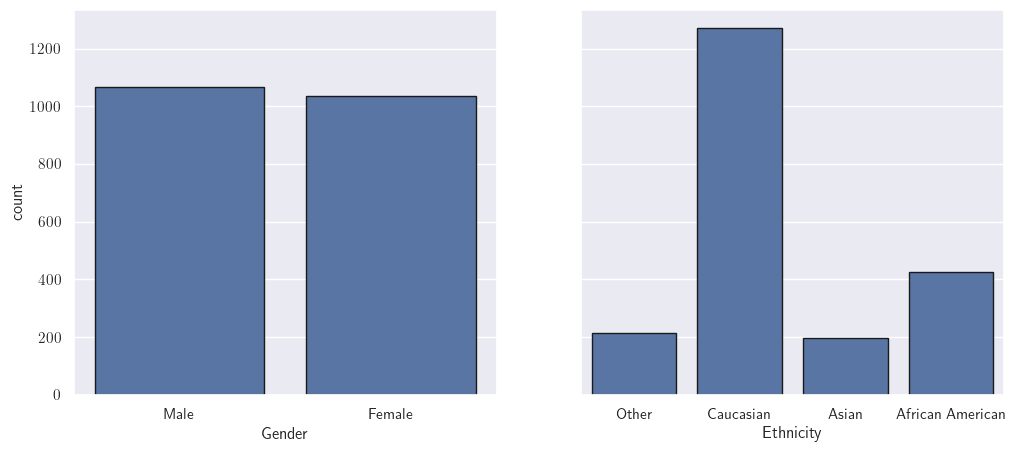

In [355]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(df, x='Gender', edgecolor='k', ax=ax1)
ax1.set_xticklabels(['Male', 'Female'])
sns.countplot(df, x='Ethnicity', edgecolor='k', ax=ax2)
plt.show()

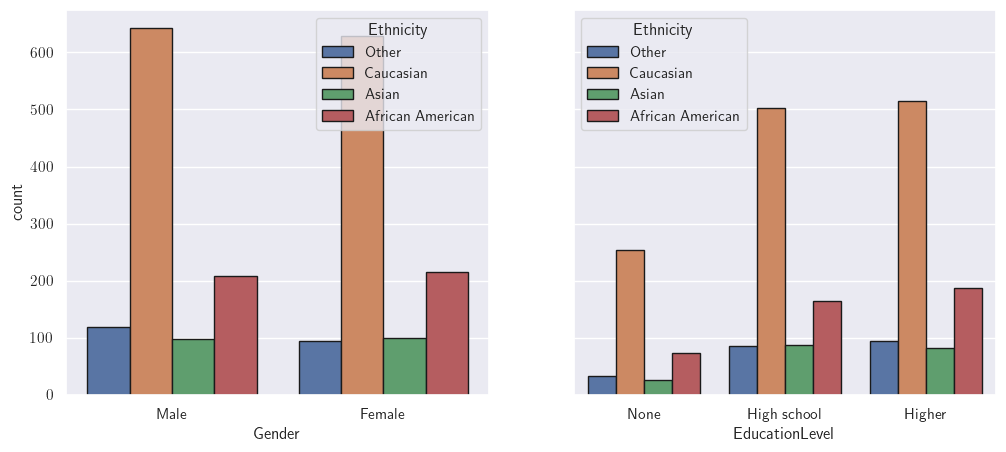

In [356]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.countplot(df, x='Gender', hue='Ethnicity', ax=ax1, edgecolor='k')
ax1.set_xticklabels(['Male', 'Female'])
sns.countplot(
    df, x='EducationLevel', hue='Ethnicity',
    order=['None', 'High school', 'Higher'], ax=ax2, edgecolor='k'
)
plt.show()

In [357]:
# Separating out the numerical columns for analysis

numeric_cols = [
    'Age',
    'BMI',
    'AlcoholConsumption',
    'PhysicalActivity',
    'DietQuality',
    'SleepQuality',
    'SystolicBP',
    'DiastolicBP',
    'CholesterolTotal',
    'CholesterolLDL',
    'CholesterolHDL',
    'CholesterolTriglycerides',
    'UPDRS',
    'MoCA',
    'FunctionalAssessment'
]

df_numeric = df[numeric_cols]

It is quite interesting that these variables are really correlated. One should expect that some these metrics to be relatively highly correlated. Nevertheless, certain patterns could be inferred which coincide with expectations (even though these do not show 'high' correlations).

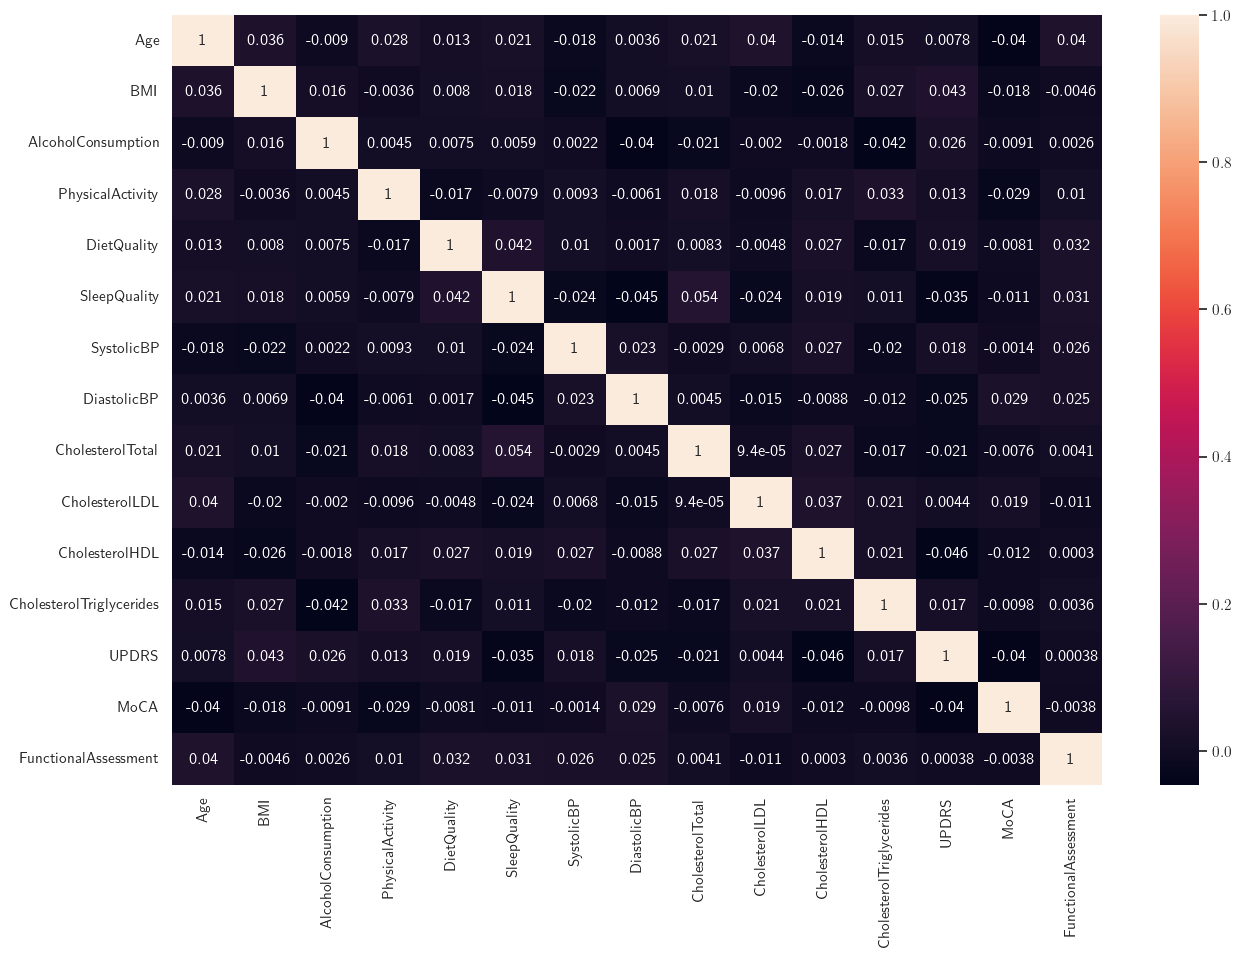

In [359]:
# Are there much correlation between these attributes?

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_numeric.corr(), annot=True, ax=ax)
plt.show()

We should visualize the distribution of these variables to check for the presence of outliers. We observe that the dataset is quite balanced in terms of these metrics with some outliers. The outliers can be see in the boxplots where the whiskers represent the $1^{\rm{st}}$ to $99^{\rm{th}}$ percentiles.

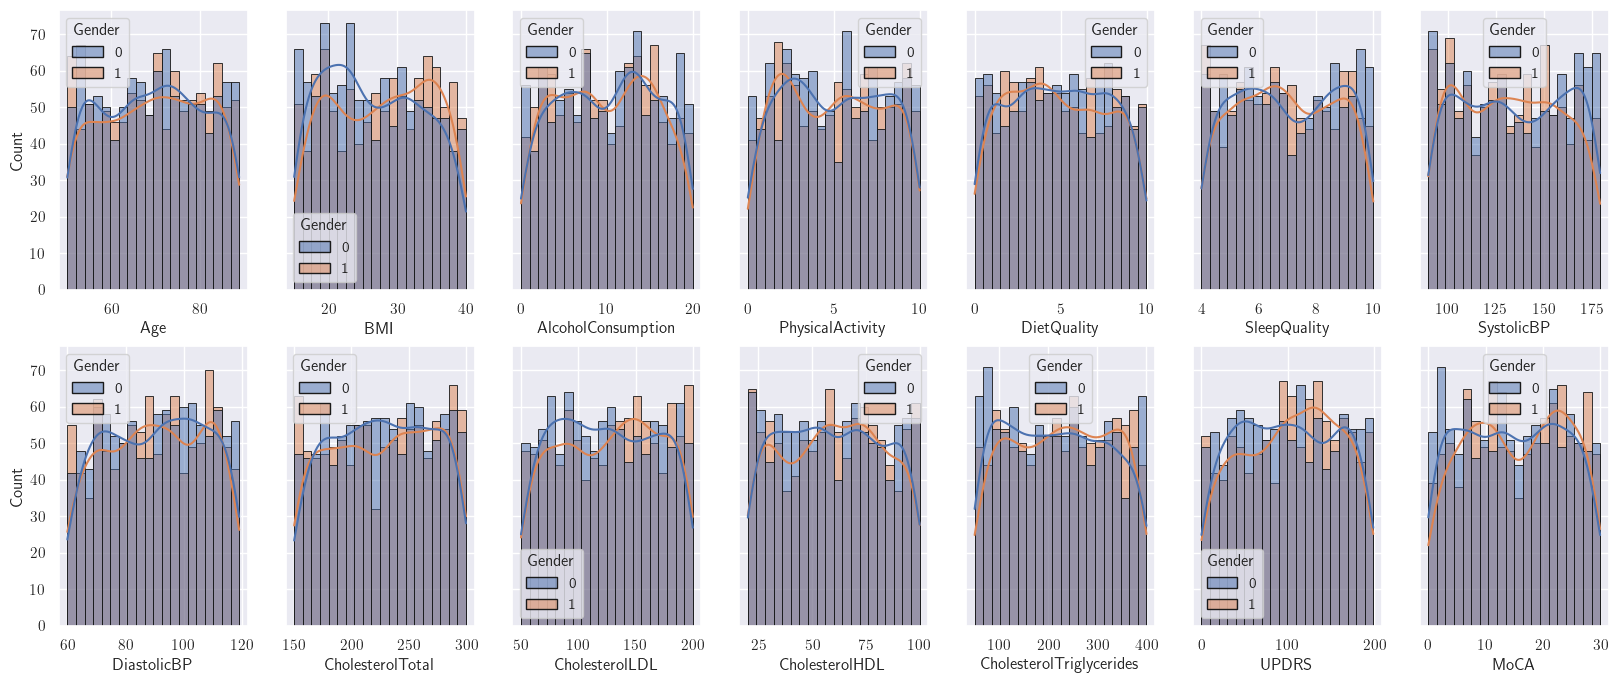

In [361]:
rows = 2
columns = 7

fig, ax = plt.subplots(rows, columns, figsize=(20, 8), sharey=True)

for col, ax in zip(numeric_cols, ax.ravel()):
    sns.histplot(df, x=df_numeric[col], bins=20, ax=ax, hue=df['Gender'], edgecolor='k', kde=True)

plt.show()

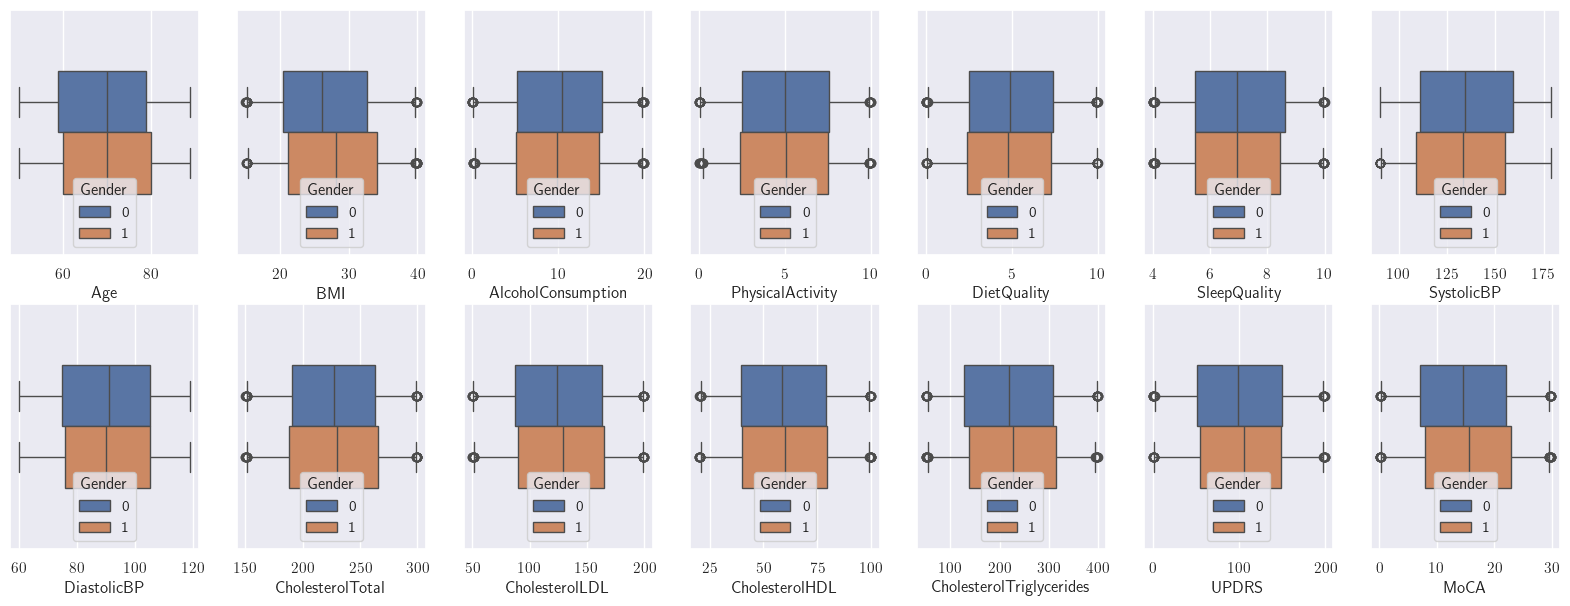

In [362]:
fig, ax = plt.subplots(rows, columns, figsize=(20, 7))

for col, ax in zip(numeric_cols, ax.ravel()):
    sns.boxplot(
        df, x=df_numeric[col], hue=df['Gender'],
        width=0.5, whis=[1, 99], ax=ax
    )
plt.show()

It is very evident, due to the fact that there are no extremes in any variable, that the numerical features are not normally distributed. However, producing Q-Q plots of these variables reveal that that central regions are normal to an appreciable degree. Hence, we can hope to perform $t$-test on these variables and perform some hypothesis testing. 

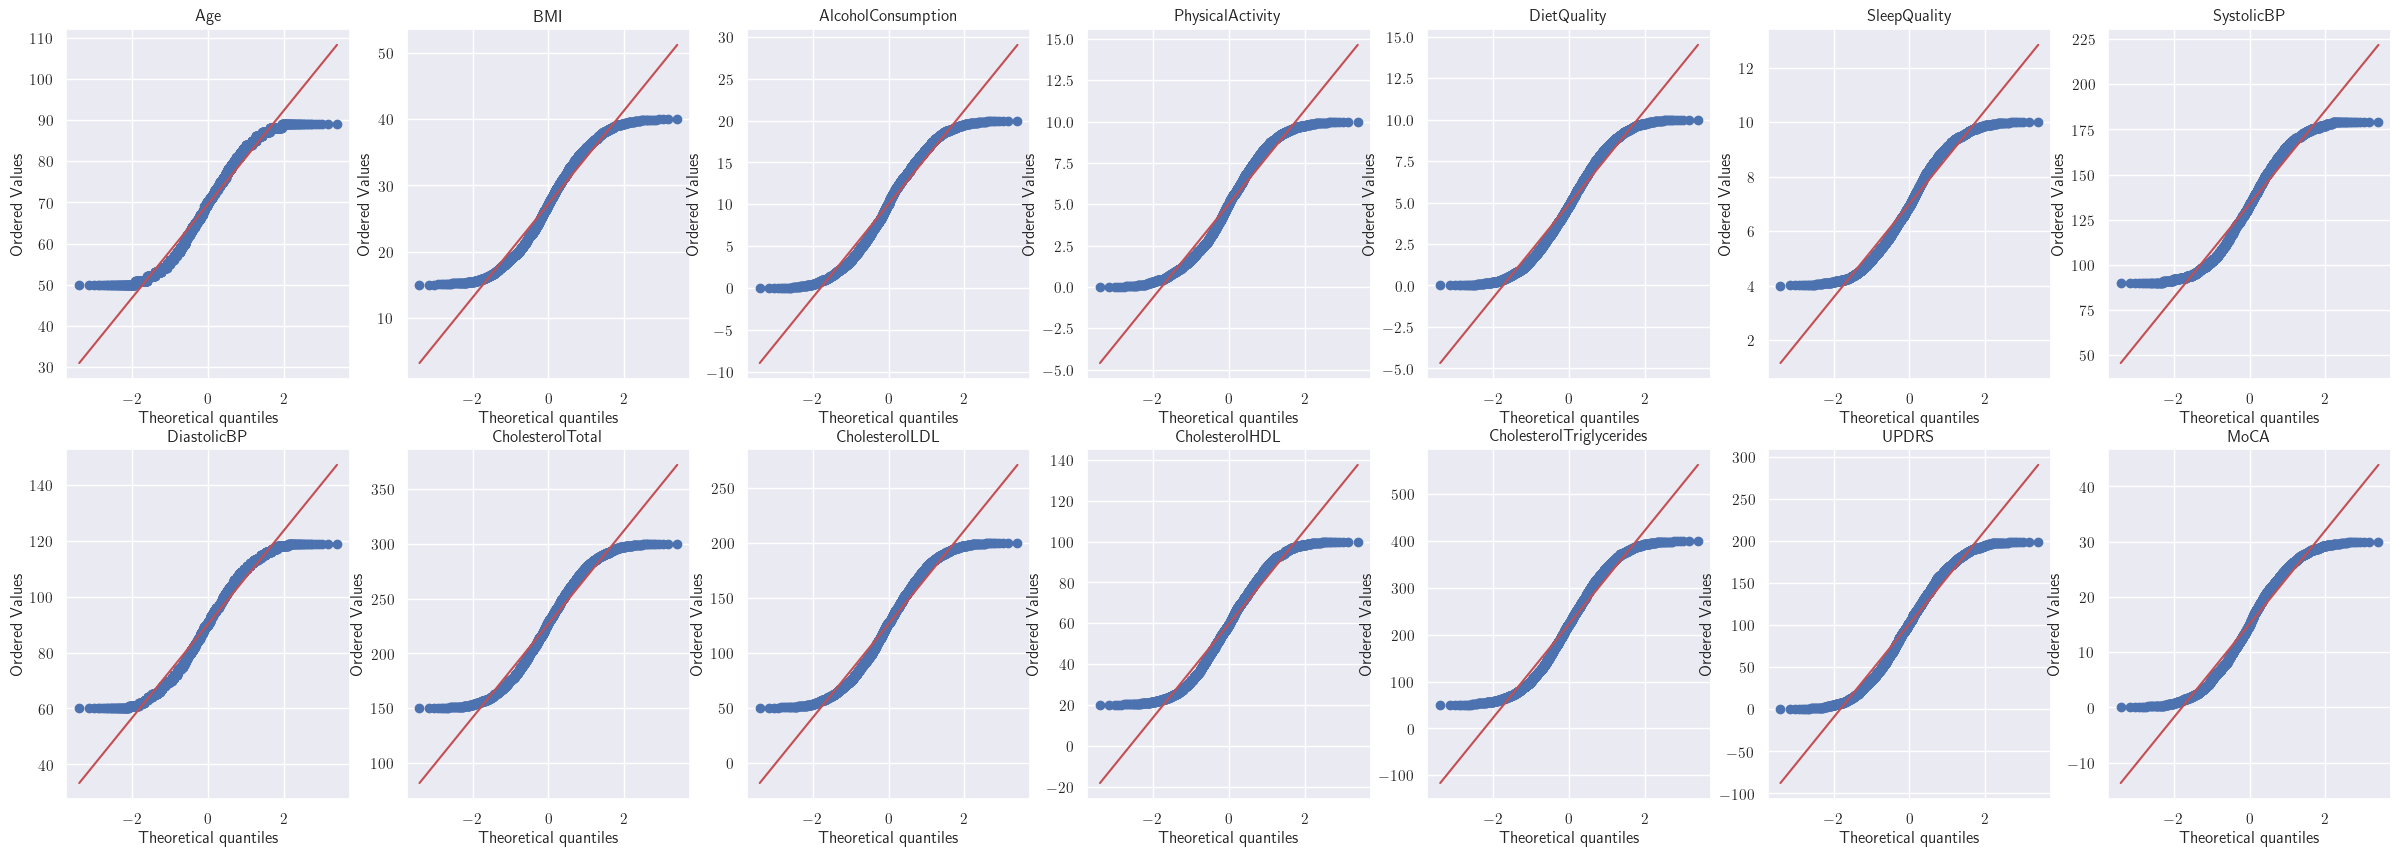

In [364]:
fig, ax = plt.subplots(rows, columns, figsize=(30, 10))

for col, ax in zip(numeric_cols, ax.ravel()):
    stats.probplot(df_numeric[col], dist='norm', plot=ax)
    ax.set_title(col)
plt.show()

Now, with all the numerical features, certain statisical tests can be performed for the purpose of hypothesis testing. The two sample $t$-statistic is given by
$$ t_{\alpha}=\frac{\bar{x}_1-\bar{x}_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}} $$
where $\bar{x}_1$ and $\bar{x}_2$ are the sample means, $s_1$ and $s_2$ are the sample standard deviations, $n-1$ and $\alpha$ is the significance level. The sample size is actually large enough for the $t$-statistic to correspond to $z$-statistic. We can start with the null hypothesis $H_0$ that there is no statistically significant differences between the population means of the positive and negative Parkinson's diagnoses for each of the numerical features. This will help us what factors are more important in determining the onset of Parkinson's among populations.

In [366]:
# Define a function for calculating t and p-values between the numerical columns and diagnosis

def t_p_values(data, num_cols):
    test_data = {} # initialize empty dictionary for t and p-value data
    for col in num_cols:
        '''
        Separating each numerical column on the basis of positive and
        negative Parkinson's diagnoses
        '''
        positive_diagnosis = data[data['Diagnosis'] == 1][col]
        negative_diagnosis = data[data['Diagnosis'] == 0][col]

        tval, pval = ttest_ind(positive_diagnosis, negative_diagnosis)
        tcrit = stats.t.ppf(q=1-0.05/2, df=len(positive_diagnosis)+len(negative_diagnosis)-2) # critical t-value assuming two-tailed
        test_data[col] = [tval, tcrit, pval]
    
    return pd.DataFrame.from_dict(test_data, orient='index', columns=['t-value', 't_crit', 'p-value'])

test1 = t_p_values(df, numeric_cols)
print(test1)

                            t-value    t_crit       p-value
Age                        3.002990  1.961093  2.704923e-03
BMI                        1.381612  1.961093  1.672375e-01
AlcoholConsumption         1.684088  1.961093  9.231300e-02
PhysicalActivity           0.593473  1.961093  5.529285e-01
DietQuality               -1.054657  1.961093  2.917035e-01
SleepQuality              -1.987320  1.961093  4.701643e-02
SystolicBP                -0.202388  1.961093  8.396327e-01
DiastolicBP               -1.333859  1.961093  1.823947e-01
CholesterolTotal          -0.871514  1.961093  3.835729e-01
CholesterolLDL             0.674506  1.961093  5.000638e-01
CholesterolHDL            -0.900171  1.961093  3.681322e-01
CholesterolTriglycerides   0.715938  1.961093  4.741088e-01
UPDRS                     19.895695  1.961093  7.642746e-81
MoCA                      -8.059952  1.961093  1.266828e-15
FunctionalAssessment     -10.591469  1.961093  1.420693e-25


The $t$-test agrees with some of the obvious markers of PD. We observe that cognitive tests such as UPDRS, MoCA and Functional Assessment yield vanishingly small $p$-values of $7.64\times 10^{-81}$ , $1.27\times 10^{-15}$, $1.42\times 10^{-25}$ respectively. The other marker is age with $p=0.0027$, which is also a statistically significant marker. The remaining numerical features do not display any statistically significant departures between the means of the two classes.

# Machine learning and classification

In [369]:
# Dropping that PatientID column since it is unimportant

df.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

We need to perform enconding and scaling of the attributes. Ordinal encoding makes sense for education level since there is a natural order in that category. The ethnicity column is encoding in the One-Hot way since it lacks an order. All the other categorical features are binary and are fine the way they are. Finally, the continuous-valued columns are standardized using a standard scaler.

In [371]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

'''
Performing One Hot and Ordinal encodings on enthicity and education level
'''
ct = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), ['Ethnicity']),
        ('oe', OrdinalEncoder(categories=[['None', 'High school', 'Higher']]), ['EducationLevel']),
        ('sc', StandardScaler(), numeric_cols)
    ], remainder='passthrough'
)

ct.set_output(transform='pandas')
X = ct.fit_transform(X)

X.head()

,ohe__Ethnicity_African American,ohe__Ethnicity_Asian,ohe__Ethnicity_Caucasian,ohe__Ethnicity_Other,oe__EducationLevel,sc__Age,sc__BMI,sc__AlcoholConsumption,sc__PhysicalActivity,sc__DietQuality,...,remainder__Diabetes,remainder__Depression,remainder__Stroke,remainder__Tremor,remainder__Rigidity,remainder__Bradykinesia,remainder__PosturalInstability,remainder__SpeechProblems,remainder__SleepDisorders,remainder__Constipation
0,0.0,0.0,0.0,1.0,1.0,1.328366,-1.053179,-0.867475,-1.258035,-0.354851,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,2.0,0.465684,-1.521172,-0.705769,1.173999,1.253913,...,0,0,0,0,1,0,1,0,1,0
2,0.0,0.0,1.0,0.0,0.0,0.034343,-1.643161,-1.371569,-1.661943,0.552304,...,1,0,0,1,0,0,0,1,0,1
3,0.0,0.0,1.0,0.0,0.0,-1.518484,-1.631183,-0.711021,-1.259978,0.627607,...,0,0,0,1,1,1,0,0,0,1
4,0.0,0.0,1.0,0.0,1.0,1.500903,-1.192477,-0.046638,-1.324484,-0.088920,...,0,0,0,0,0,0,1,0,1,0


In [375]:
def ParamSearchModels(X, y):
    '''
    Specifying the list of regression algorithms and hyper-parameters
    '''
    algorithms={
        'Logistic Regressor' : {
            'model'  : LogisticRegression(),
            'params' : {
                'penalty' : ['l1', 'l2'],
                'C'       : [0.01, 0.1, 1.0],
                'solver'  : ['lbfgs', 'liblinear']
            }
        },
        'Random Forest Classifier' : {
            'model'    : RandomForestClassifier(),
            'params'   : {
                'n_estimators' : [50, 100, 150, 200],
                'max_depth'    : [5, 10, 15],
                'criterion'    : ['gini', 'entropy']
            }
        },
        'XG_Boost'     : {
            'model'    : XGBClassifier(),
            'params'   : {
                'n_estimators' : [50, 100, 150, 200],
                'max_depth'    : [5, 10, 15],
                'gamma'        : [0.01, 0.05, 0.1],
                'learning_rate': [0.01, 0.1, 1]
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size=0.2, random_state=10)
    
    for algorithm, config in algorithms.items():
        GS = GridSearchCV( 
            config['model'], 
            config['params'], 
            cv=cv, 
            return_train_score=False,
            scoring = 'accuracy', 
            n_jobs = -1
        )
        GS.fit(X, y)
        scores.append(
            {
                'model'       : algorithm,
                'best_score'  : GS.best_score_,
                'best_params' : GS.best_params_ 
            }
        )

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [377]:
GS_params_data = ParamSearchModels(X, y)

GS_params_data

,model,best_score,best_params
0,Logistic Regressor,0.811876,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline..."
1,Random Forest Classifier,0.918290,"{'criterion': 'entropy', 'max_depth': 15, 'n_e..."
2,XG_Boost,0.924466,"{'gamma': 0.1, 'learning_rate': 0.1, 'max_dept..."
